In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

import statsmodels.api as sm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('mmm.csv').iloc[:,1:]
df

,TV,Radio,Banners,Sales
0,13528.10,0.00,0.00,9779.80
1,0.00,5349.65,2218.93,13245.19
2,0.00,4235.86,2046.96,12022.66
3,0.00,3562.21,0.00,8846.95
4,0.00,0.00,2187.29,9797.07
...,...,...,...,...
195,0.00,0.00,1691.68,9030.17
196,11543.58,4615.35,2518.88,15904.11
197,0.00,4556.16,1919.19,12839.29
198,0.00,0.00,1707.65,9063.45


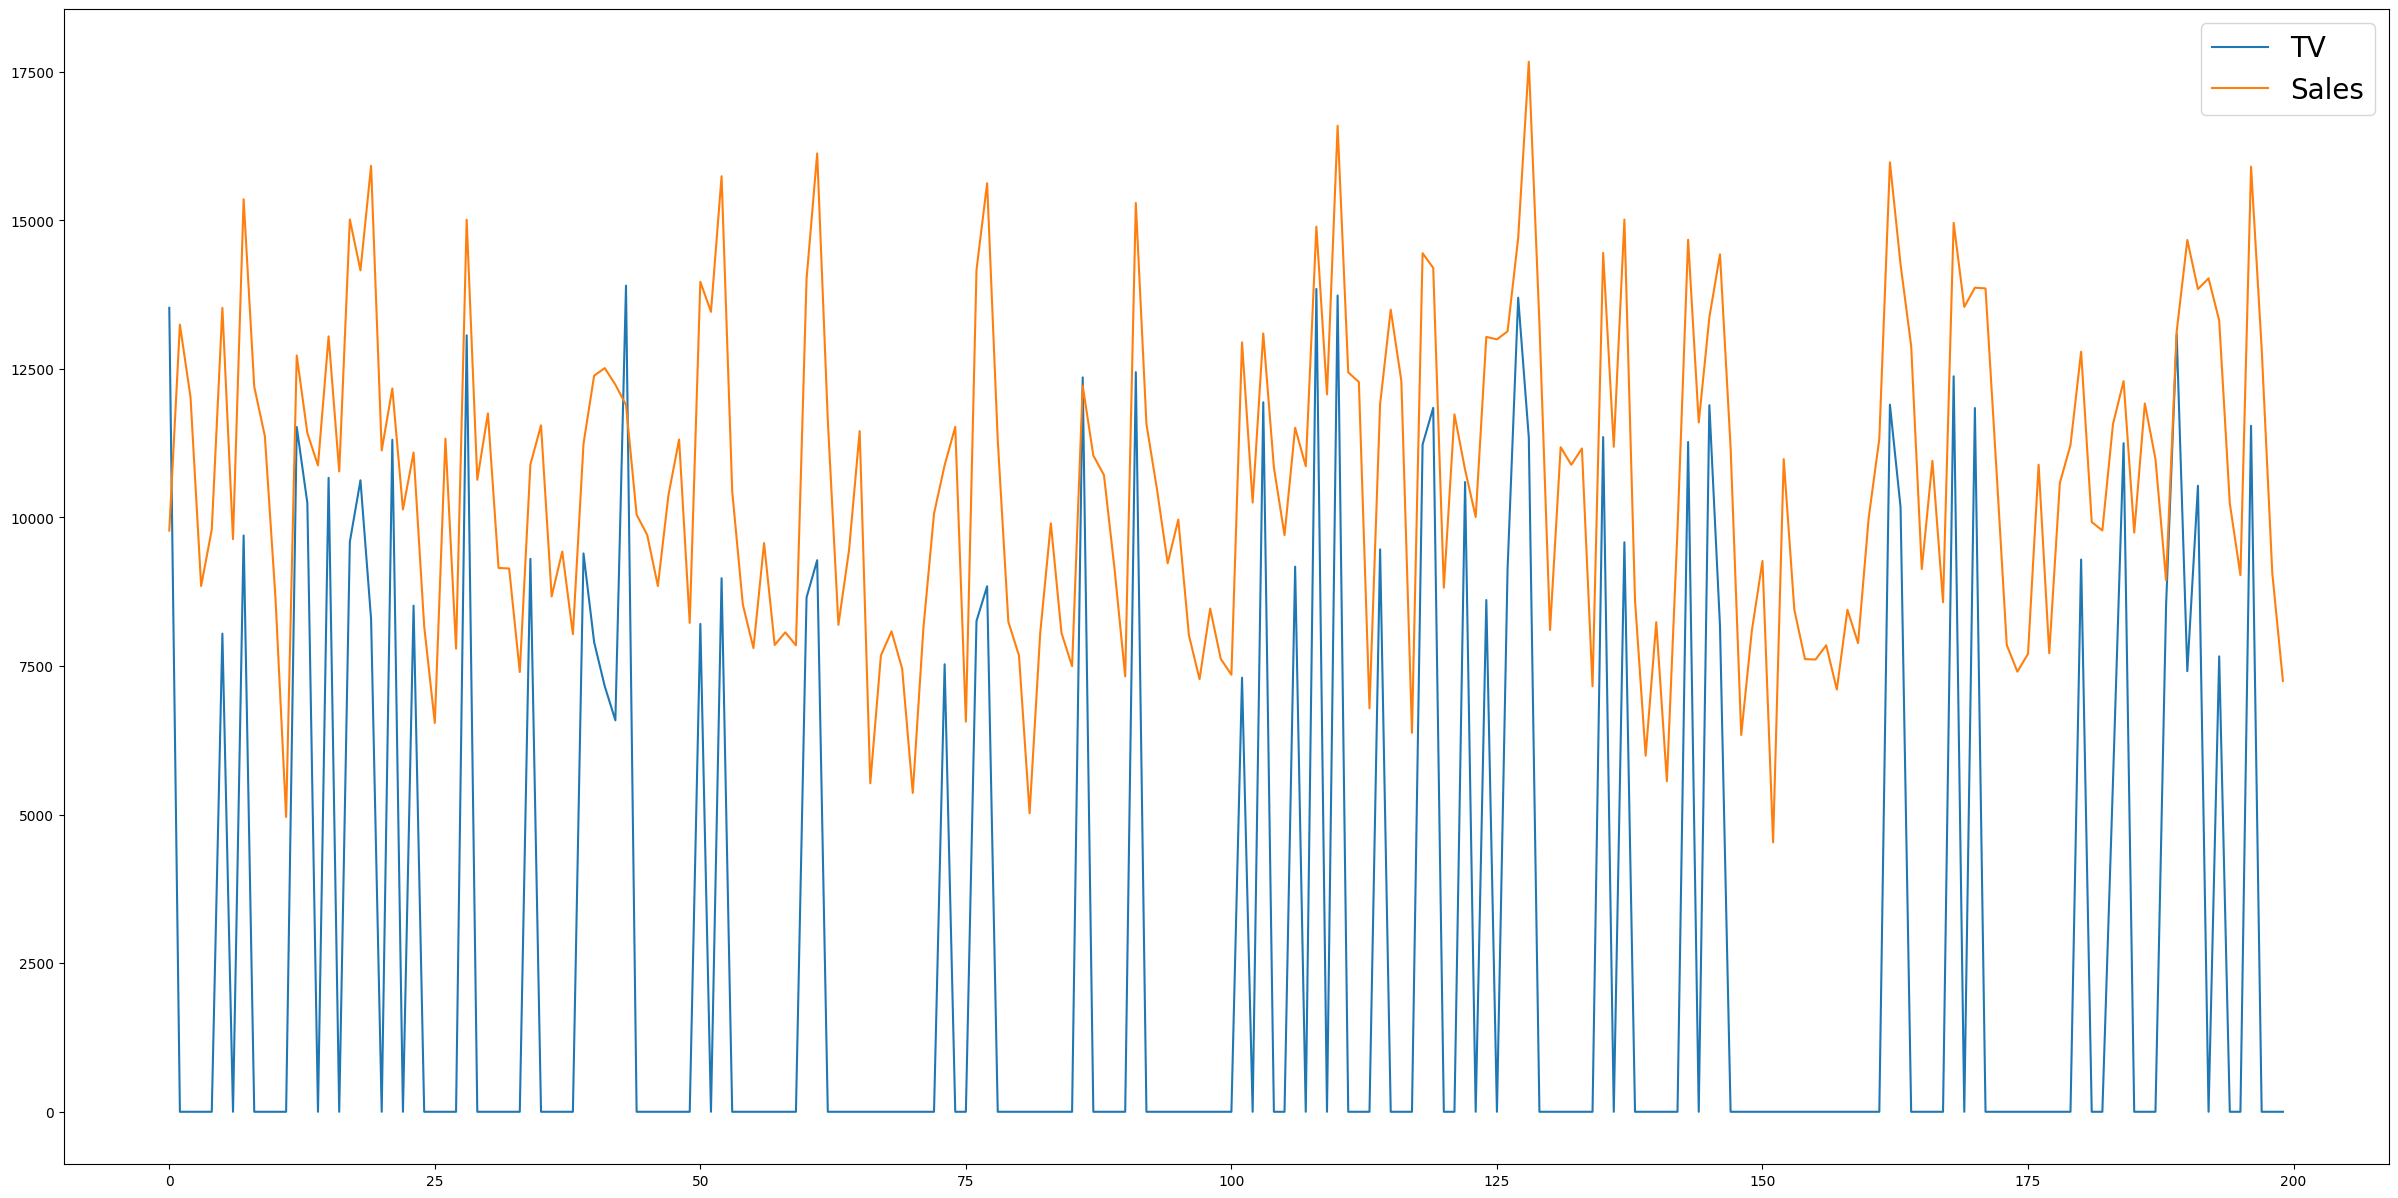

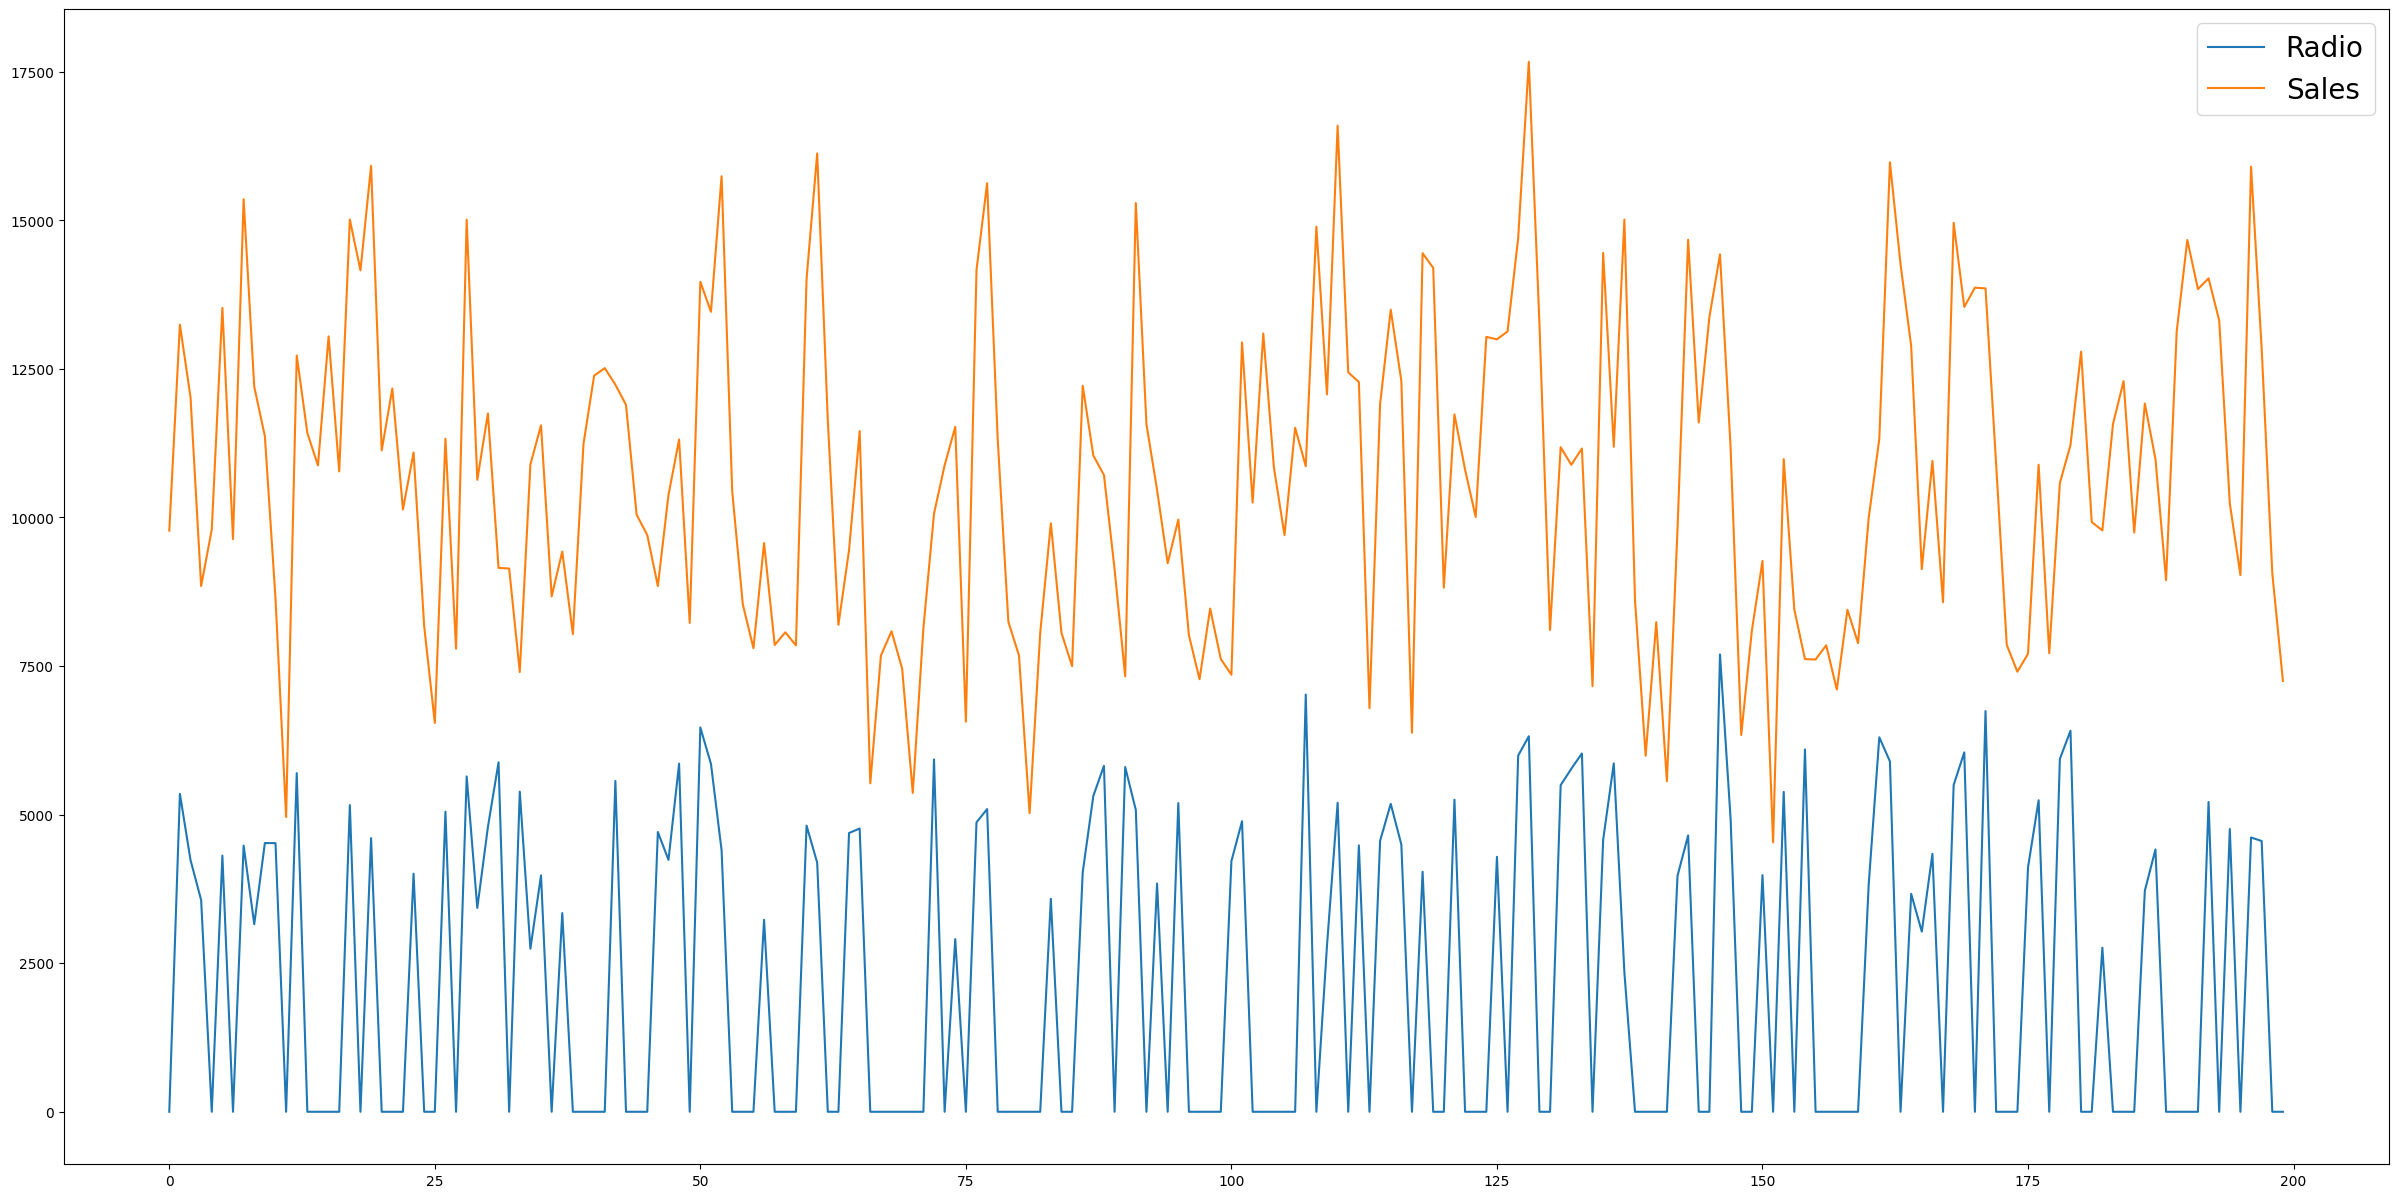

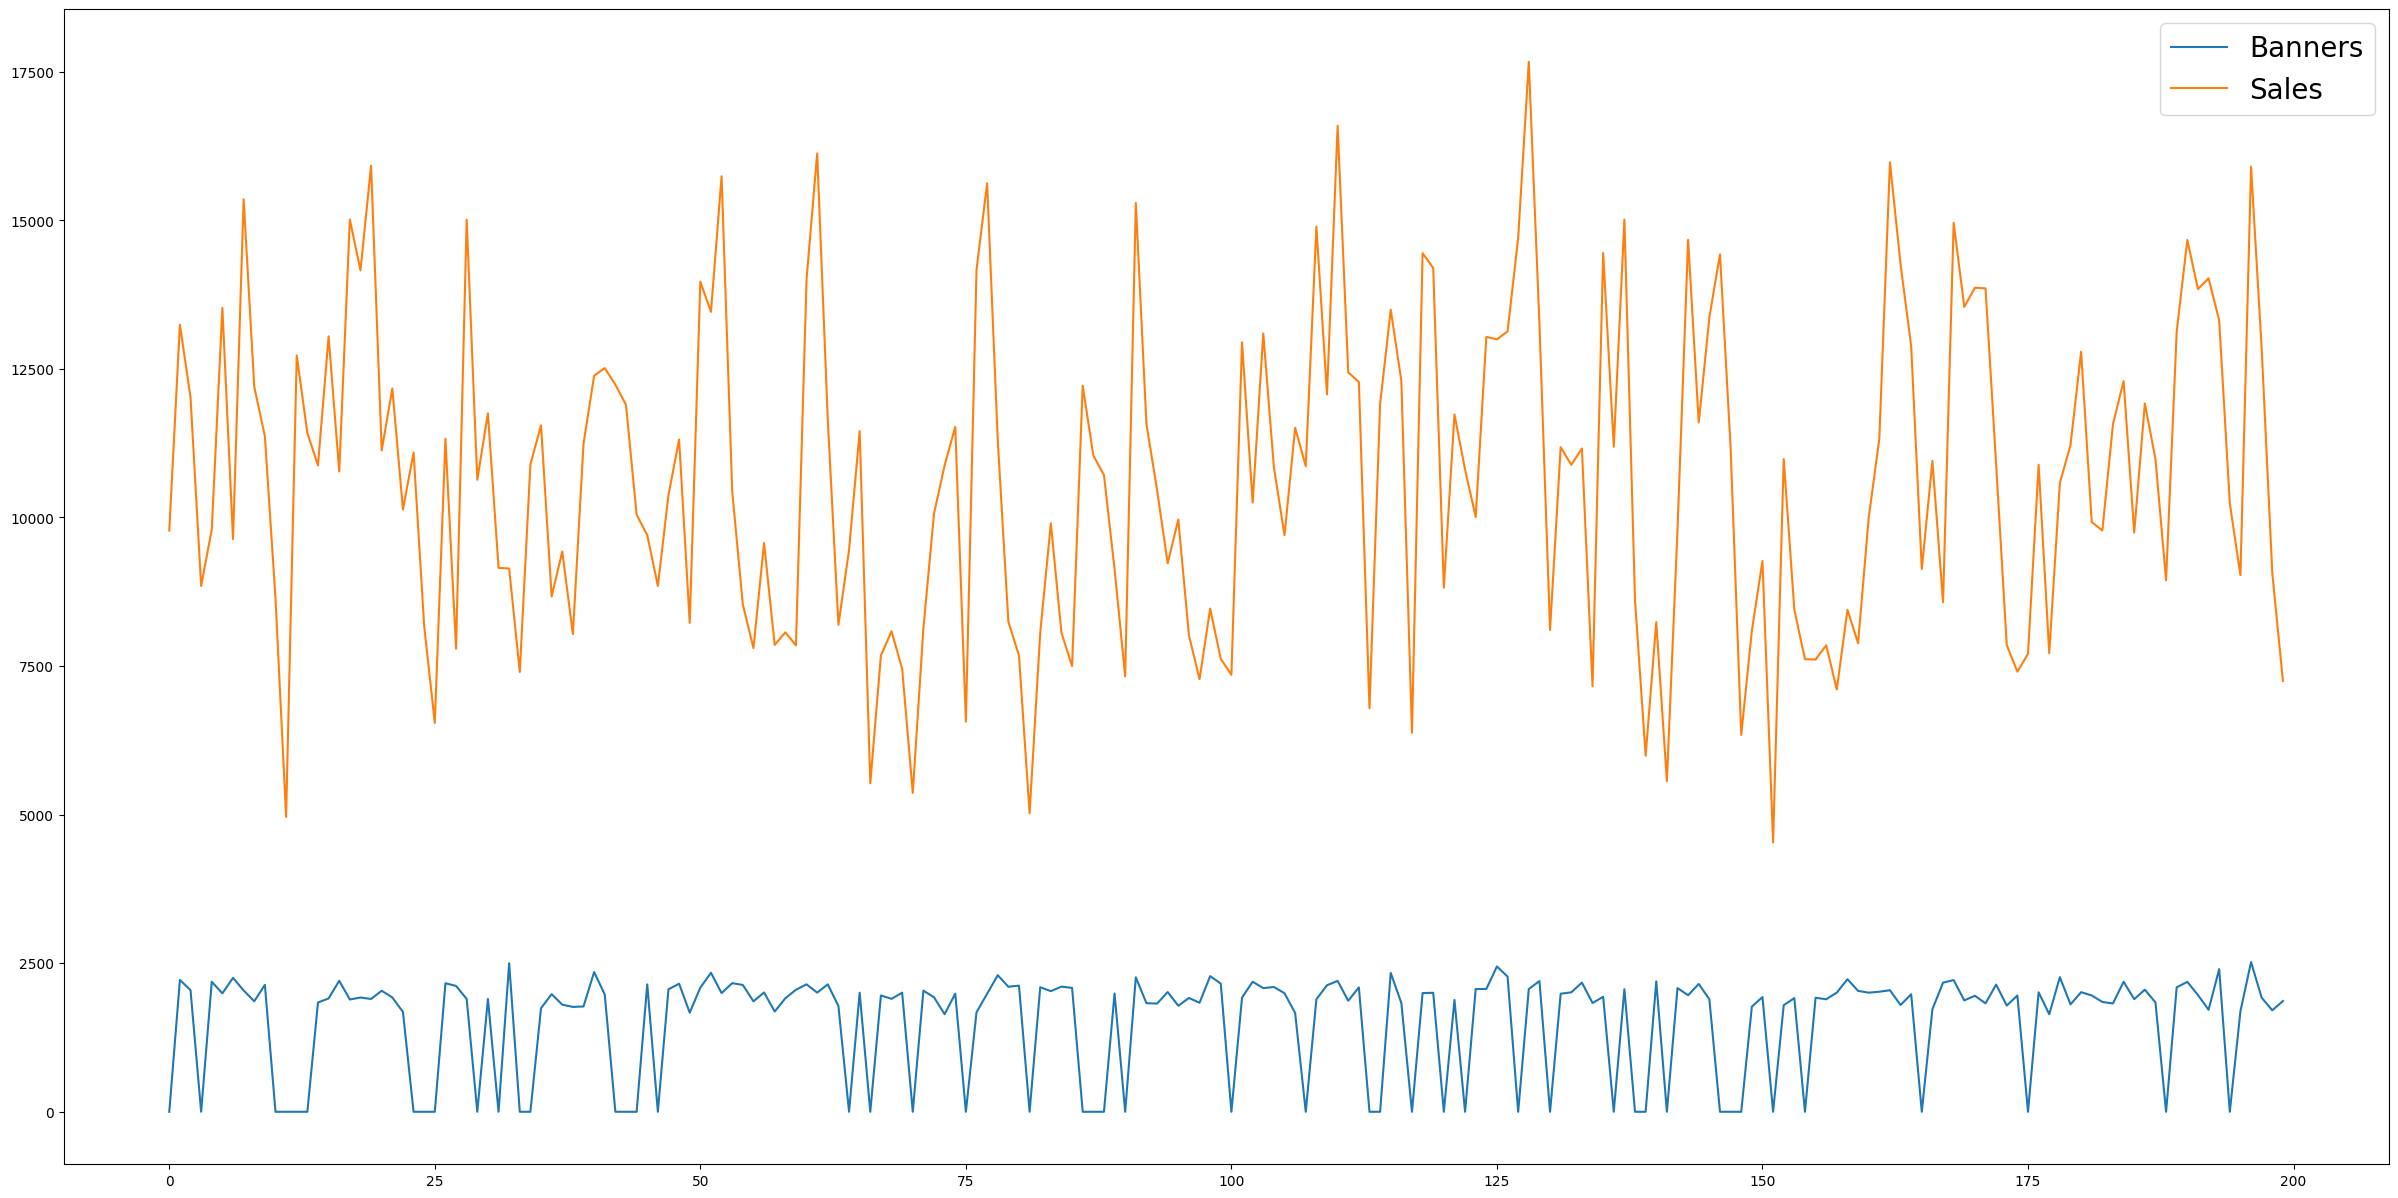

In [3]:
for i in df.iloc[:,:-1].columns:
    plt.figure(figsize=(30,15))
    plt.plot(df[i],label=i)
    plt.plot(df['Sales'],label='Sales')
    plt.legend(fontsize=20)
    plt.show()

In [4]:
X = df.iloc[:,:3]
X

,TV,Radio,Banners
0,13528.10,0.00,0.00
1,0.00,5349.65,2218.93
2,0.00,4235.86,2046.96
3,0.00,3562.21,0.00
4,0.00,0.00,2187.29
...,...,...,...
195,0.00,0.00,1691.68
196,11543.58,4615.35,2518.88
197,0.00,4556.16,1919.19
198,0.00,0.00,1707.65


FIRST WE BUILD A SIMPLE LINEAR REGRESSION MODEL AND CHECK HOW IT PERFORMS AND ANALYZE THE CO-EFFICIENTS.

In [5]:
mod = sm.OLS(df['Sales'],X)
res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Sales   R-squared (uncentered):                   0.919
Model:                            OLS   Adj. R-squared (uncentered):              0.918
Method:                 Least Squares   F-statistic:                              748.4
Date:                Thu, 30 Mar 2023   Prob (F-statistic):                   2.19e-107
Time:                        13:28:04   Log-Likelihood:                         -1893.2
No. Observations:                 200   AIC:                                      3792.
Df Residuals:                     197   BIC:                                      3802.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

ALL THE CO-EFFICIENTS ARE SIGNIFICANT SO NOW DO TRAIN AND TESTING.

In [6]:
x_train = X.iloc[:160]
x_test = X.iloc[160:]

y_train = df['Sales'].iloc[:160]
y_test = df['Sales'].iloc[160:]

lr.fit(x_train,y_train)
lr.score(x_test,y_test)

0.7371975592752755

1) We assume that the more money you spend on advertising, the higher your sales get. However, the increase gets weaker the more we spend.


2) This is called a saturation effect or the effect of diminishing returns.


3) For example, increasing the TV spends from 0 to 1000000 ruppees increases our sales a lot, but increasing it from 1000000  to 2000000  does not do that much anymore.


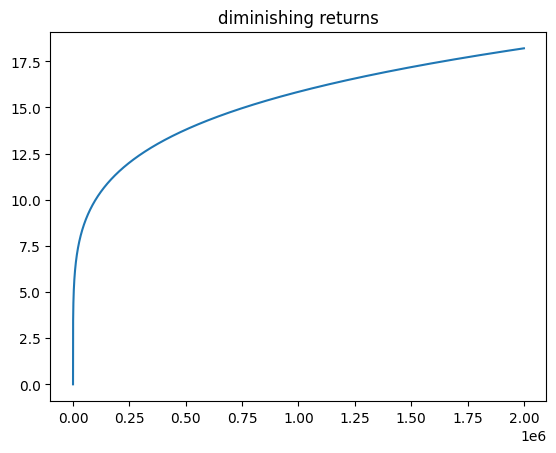

In [7]:
l = []
for i in range(2000000):
    l.append(i**0.2)
    
plt.plot(l)
plt.title('diminishing returns')
plt.show()

If you spend money on advertising week T, often people will not immediately buy your product, but a few (let us say x) weeks later. 

This is because the product might be expensive, and people want to think about it carefully or compare it to similar products from other companies. 

Whatever the reason might be, the sale in week T + x is partially caused by the advertising you played in week T, so it should also get some credits. 

'THIS IS CALLED THE CARRY-OVER OR LAGGED EFFECT.'

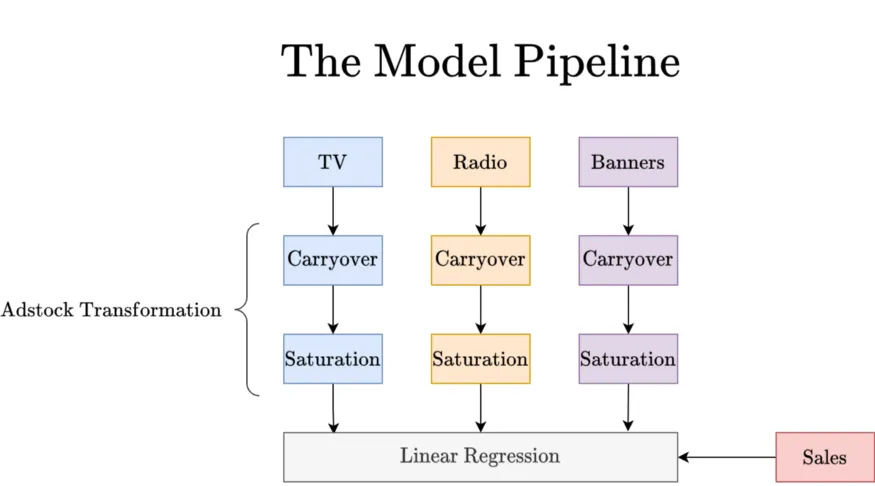

In [8]:
# NOW WRITING THE FUNCTIONS FOR SATURATION EFFECT AND CARRY OVER EFFECT

def  ExponentialCarryover(adstock_rate, impressions):
    adstocked_media = []
    for i in range(len(impressions)):
        if i == 0:
            adstocked_media.append(impressions[i])
        else:
            adstocked_media.append(impressions[i] + adstock_rate * adstocked_media[i-1])
    return adstocked_media

def saturation(a,x):
    listed = []
    for i in x:
        listed.append(i**a)
    return pd.DataFrame(listed)

FIRST WE IMPLEMENT THE EXPONENTIAL CARRY OVER EFFECT AND SEE HOW IT PERFORMS TO A SIMPLE MODEL.

HERE THE PARAMETERS OF EACH OF THE INDEPENDENT VARIABLES NEEDS TO BE DETERMINED FOR OPTIMAL PERFORMANCE. 

SO WE USE    'scipy.minimze'     FUNCTION AND TRY TO MINIMIZE NEGATIVE R^2  WHICH WOULD IN TURN MAXIMIZE R^2.

SIMPLE LINEAR REGRESSION MODEL IS USED.

In [9]:
def objective_function(params):
    a1, a2, a3= params
    
    X1 = X.copy()
    X1['TV'] = ExponentialCarryover(a1, X['TV'])
    X1['Radio'] = ExponentialCarryover(a2, X['Radio'])
    X1['Banners'] = ExponentialCarryover(a3, X['Banners'])
    
    lr.fit(X1, df['Sales'])
    return -lr.score(X1, df['Sales'])  # return the negative score since minimize() minimizes the objective function

# define the initial guesses for a1, a2, and a3
initial_guess = [0.1, 0.1, 0.1]

# define the bounds for a1, a2, and a3 (optional)
bounds = [(0, 1), (0, 1), (0, 1)]

# run the optimization
result = minimize(objective_function, initial_guess, bounds=bounds)

# extract the optimized values of a1, a2, and a3
a1, a2, a3 = result.x

X1 = X.copy()
X1['TV'] = ExponentialCarryover(a1, X['TV'])
X1['Radio'] = ExponentialCarryover(a2, X['Radio'])
X1['Banners'] = ExponentialCarryover(a3, X['Banners'])

mod = sm.OLS(df['Sales'],X1)
res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Sales   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              1889.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):                   7.71e-145
Time:                        13:28:05   Log-Likelihood:                         -1805.6
No. Observations:                 200   AIC:                                      3617.
Df Residuals:                     197   BIC:                                      3627.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

ALL THE CO-EFFICIENTS ARE SIGNIFICANT.

NOW RUNNING THE MODEL FOR TEST DATA

In [10]:
x_train = X1.iloc[:160]
x_test = X1.iloc[160:]

y_train = df['Sales'].iloc[:160]
y_test = df['Sales'].iloc[160:]

lr.fit(x_train,y_train)
lr.score(x_test,y_test)

0.9486245037657737

HERE YOU CAN SEE THAT OUR R^2 SCORE VALUE DRASTICALLY INCREASED FOR THE 'TEST DATASET' COMPARED TO THE NORMAL MODEL.

NEXT WE COMBINE CARRY OVER AND THEN SATURATION EFFECT IN HOPE TO SEE BETTER RESULT.

In [11]:
def objective_function(params):
    a1, a2, a3,b1,b2,b3 = params
    
    X1 = X.copy()
    X1['TV'] = ExponentialCarryover(a1, X['TV'])
    X1['Radio'] = ExponentialCarryover(a2, X['Radio'])
    X1['Banners'] = ExponentialCarryover(a3, X['Banners'])
    
    
    X1['TV'] = saturation(b1, X1['TV'])
    X1['Radio'] = saturation(b2, X1['Radio'])
    X1['Banners'] = saturation(b3, X1['Banners'])
    
    lr.fit(X1, df['Sales'])
    return -lr.score(X1, df['Sales'])  # return the negative score since minimize() minimizes the objective function

# define the initial guesses for a1, a2, and a3
initial_guess = [0.1, 0.1, 0.1,0.1,0.1,0.1]

# define the bounds for a1, a2, and a3 (optional)
bounds = [(0, 1), (0, 1), (0, 1),(0, 1), (0, 1), (0, 1)]

# run the optimization
result = minimize(objective_function, initial_guess, bounds=bounds)

# extract the optimized values of a1, a2, and a3
a1, a2, a3, b1, b2, b3 = result.x

X1 = X.copy()
X1['TV'] = ExponentialCarryover(a1, X['TV'])
X1['Radio'] = ExponentialCarryover(a2, X['Radio'])
X1['Banners'] = ExponentialCarryover(a3, X['Banners'])

X1['TV'] = saturation(b1, X1['TV'])
X1['Radio'] = saturation(b2, X1['Radio'])
X1['Banners'] = saturation(b3, X1['Banners'])

mod = sm.OLS(df['Sales'],X1)
res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Sales   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                              2368.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):                   3.26e-154
Time:                        13:28:06   Log-Likelihood:                         -1783.7
No. Observations:                 200   AIC:                                      3573.
Df Residuals:                     197   BIC:                                      3583.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [12]:
x_train = X1.iloc[:160]
x_test = X1.iloc[160:]

y_train = df['Sales'].iloc[:160]
y_test = df['Sales'].iloc[160:]

lr.fit(x_train,y_train)
lr.score(x_test,y_test)

0.9563786005767076

THE RESULTS HAVE SLIGHTLY IMPOROVED !  